### Importing Packages

In [1]:
import numpy as np
import pandas as pd

### Creating Dataframe

In [2]:
df = pd.read_csv('spam.csv', encoding = 'cp1252')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Dropping Unnecessary Columns

In [4]:
df = df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

### Encoding Categorical Labels to Numerical

In [5]:
from sklearn.preprocessing import LabelEncoder

# encode categorical labels to numerical labels
encoder = LabelEncoder()
df['v1'] = encoder.fit_transform(df['v1'])

### Checking for Duplicates/Missing Data

In [6]:
# check for duplicates
df[df.duplicated()]

,v1,v2
102,0,As per your request 'Melle Melle (Oru Minnamin...
153,0,As per your request 'Melle Melle (Oru Minnamin...
206,0,"As I entered my cabin my PA said, '' Happy B'd..."
222,0,"Sorry, I'll call later"
325,0,No calls..messages..missed calls
...,...,...
5524,1,You are awarded a SiPix Digital Camera! call 0...
5535,0,"I know you are thinkin malaria. But relax, chi..."
5539,0,Just sleeping..and surfing
5553,0,Hahaha..use your brain dear


In [7]:
# check for missing values
df.isnull().values.any()

False

### Plotting Class Densities

<Axes: title={'center': 'Occurences of Each Label'}, xlabel='Label', ylabel='Count'>

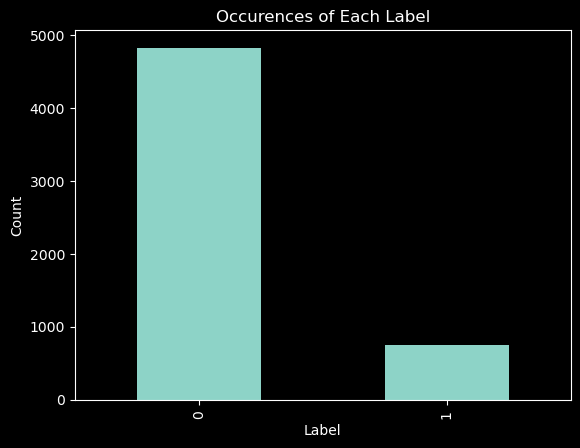

In [8]:
import matplotlib.pyplot as plt
df['v1'].value_counts().plot(kind = 'bar', xlabel = "Label", 
                             ylabel = 'Count', title = "Occurences of Each Label")

### Filtering Dataframe based on Entry Length

In [9]:
# check length of messages
df['length'] = df['v2'].apply(len)
df['length'].value_counts()

length
22     123
24     100
32      96
23      94
26      87
      ... 
234      1
461      1
295      1
242      1
273      1
Name: count, Length: 274, dtype: int64

In [10]:
df = df[df['v2'].apply(lambda x: len(x) < 200)]

### Removing upper cases, punctuation, non-alphanumeric characters

In [11]:
import string
df['v2'] = df['v2'].str.lower()
df['v2'] = df['v2'].str.translate(str.maketrans('', '', string.punctuation))
df['v2'] = df['v2'].str.replace(r'[^a-zA-Z\s]', '', regex = True)

In [12]:
df.head

<bound method NDFrame.head of       v1                                                 v2  length
0      0  go until jurong point crazy available only in ...     111
1      0                            ok lar joking wif u oni      29
2      1  free entry in  a wkly comp to win fa cup final...     155
3      0        u dun say so early hor u c already then say      49
4      0  nah i dont think he goes to usf he lives aroun...      61
...   ..                                                ...     ...
5567   1  this is the nd time we have tried  contact u u...     161
5568   0                 will  b going to esplanade fr home      37
5569   0  pity  was in mood for that soany other suggest...      57
5570   0  the guy did some bitching but i acted like id ...     125
5571   0                          rofl its true to its name      26

[5458 rows x 3 columns]>

In [13]:
import nltk
from collections import Counter

nltk.download('punkt_tab')
df['v3'] = df['v2'].apply(lambda x: nltk.tokenize.word_tokenize(x))

word_counter = Counter(j for i in df['v3'] for j in i)
word_to_idx = {'<PAD>': 0, '<UNK>': 1}

word_to_idx.update({word: i+2 for i, (word, _) in enumerate(word_counter.most_common())})

max_len = max(df['v3'].apply(len))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ahhussain1017/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, dataframe, tokenizer, word_to_idx, max_len):
        self.texts = dataframe['v2'].tolist()
        self.labels = dataframe['v1'].tolist()
        self.tokenizer = tokenizer
        self.word_to_idx = word_to_idx
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokenized_text = self.tokenizer(text.lower())
        encoded_text = [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in tokenized_text]

        padded_text = encoded_text + [self.word_to_idx['<PAD>']] * (self.max_len - len(encoded_text))
        padded_text = padded_text[:self.max_len]

        return torch.tensor(padded_text, dtype = torch.long), torch.tensor(label, dtype = torch.long)

In [15]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

train_dataset = SpamDataset(train_df, word_tokenize, word_to_idx, max_len)
test_dataset = SpamDataset(test_df, word_tokenize, word_to_idx, max_len)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [16]:
import torch.nn as nn
import torch.optim as optim

class SpamClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers):
        super(SpamClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        out = self.fc(hidden[-1])
        return self.softmax(out)

In [17]:
vocab_size = len(word_to_idx)
embed_dim = 50
hidden_dim = 64
output_dim = len(set(df['v1']))
num_layers = 2

model = SpamClassifier(vocab_size, embed_dim, hidden_dim, output_dim, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = .001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for data, label in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

: 

: 